# Discriminating qubit states using Qiskit

In this Jupyter notebook we show how to convert level 1 data, such as IQ data for superconducting qubits, to level 2 data, i.e. qubit states. We do this by training a discriminator using calibration circuits and create a filter, based on the fitted discriminator, which can be applied to subsequent measurement. This notebook does the following steps

1) Creates pulse schedules to run on the IBM Q devices. The schedule list has calibration schedules and experiment schedules. 

2) Use the calibration schedules to train a discriminator.

3) Create a filter from the discriminator to discriminate the qubit states for the experiment schedule.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from copy import deepcopy

%matplotlib inline
plt.rcParams['font.size'] = 16

import qiskit
from qiskit.ignis.measurement.discriminator.iq_discriminators import \
    LinearIQDiscriminator, QuadraticIQDiscriminator
from qiskit.result.models import ExperimentResultData
from qiskit import IBMQ

import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble

## 1) Creating Pulse Schedules to run on IBM Q

In [2]:
account_provider = IBMQ.load_account()
hub = account_provider.credentials.hub
group = account_provider.credentials.group
project = account_provider.credentials.project

In [3]:
provider = IBMQ.get_provider(hub=hub, group=group, project=project)
backend = provider.get_backend('ibmq_20_tokyo')
back_config = backend.configuration().to_dict()
device = pulse.PulseChannelSpec.from_backend(backend)

In [4]:
defaults = backend.defaults()

# command definition from defaults.
cmd_def = pulse.CmdDef.from_defaults(defaults.cmd_def, defaults.pulse_library)

We create schedules to measure two qubits. The calibration schedules `cal_00` and `cal_11` serve to calibrate the 0 and 1 sates of the qubits. The schedule `X90p` is our experiment where we apply a pi-half-pulse to both qubits.

In [5]:
qubits = [0, 1]
schedules = []
meas_buffer = 2
shots = 512
experiment_name = 'X90p'

meas = cmd_def.get('measure', qubits=tuple(range(20)))

# Create a calibration schedule for the ground state.
schedule_no_pi = pulse.Schedule(name='cal_00')
schedule_no_pi += meas

# Create a calibration schedule for the excited state.
schedule_pi = pulse.Schedule(name='cal_11')
for q in qubits:
    xgate = cmd_def.get('x', qubits=q)
    schedule_pi += xgate

schedule_pi += meas << (schedule_pi.duration + meas_buffer)

# Measurement schedule. Do an X90p gate on both qubits.
schedule_x90p = pulse.Schedule(name=experiment_name)
for q in qubits:
    x90p = cmd_def.get('u3', qubits=q, P0=np.pi/2., P1=0., P2=0.)
    schedule_x90p += x90p
    
schedule_x90p += meas << (schedule_x90p.duration + meas_buffer)
    
schedules = [schedule_no_pi, schedule_pi, schedule_x90p]

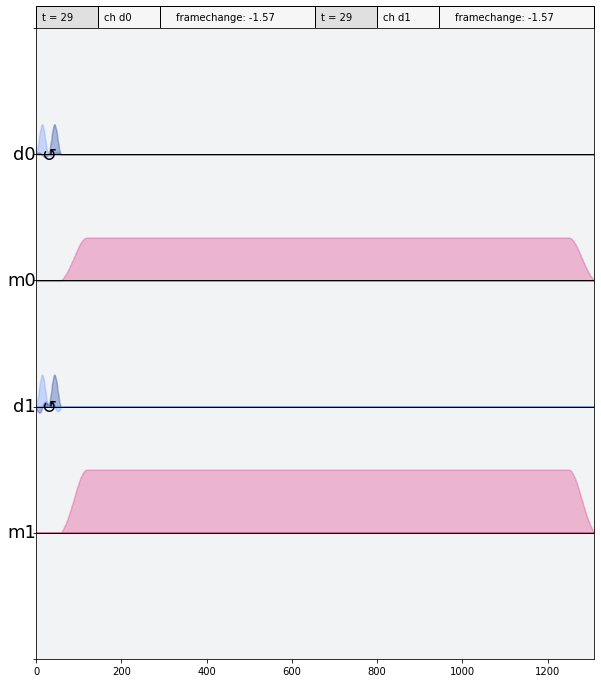

In [6]:
plt_chs = []
for q in [0, 1]:
    plt_chs.append(device.qubits[q].measure)
    plt_chs.append(device.qubits[q].drive)

schedules[2].draw(channels_to_plot=plt_chs, scaling=10.)

In [7]:
qobj = assemble(schedules, backend, meas_level=1, meas_return='single', shots=shots)

In [11]:
job = backend.run(qobj)

In [13]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [9]:
result = job.result(timeout=3600)

In [10]:
# Extract the cals from the result
def result_subset(result, names):

    new_result = deepcopy(result)
    new_results = []
    
    for res in new_result.results:
        if res.header.name in names:
            new_results.append(res)

    new_result.results = new_results
    
    return new_result

## 2) Fitting and using a discriminator

We use the calibration schedules `cal_00` and `cal_11` to fit two linear discriminant discriminators. One for each qubit. Doing so implies that the qubit-qubit correlations in the single shot data are neglected. The discrimination does not necessarily need to be done in this way. Indeed, a single discriminator could be used to account for qubit-qubit correlations. The decision boundary is however harder to illustrate since two qubits implies a 4D decision space.

In [11]:
cal_names = ['cal_00', 'cal_11']

# Results of the calibration circuits in the schedules
cal_results = result_subset(result, cal_names)

### Single-qubit discriminator

The routine below is the **core of the discriminant analysis**. A call to the constructor also fits the discriminator to the provided results. We fit one discriminator per qubit.

In [12]:
discriminators = {}

for q in qubits:
    discriminators[q] = LinearIQDiscriminator(cal_results, [q], ['0', '1'])

We can retrieve the state of an I/Q point by calling the discriminator's **discriminate(iq_data) method**. The code below illustrates this using two points in the IQ plane `(0,0)` and `(0, -2e11)`. Depending on the results, these points will correspond a $|0\rangle$ or $|1\rangle$ state of the `test_qubit`.

In [13]:
test_qubit = 0
test_iq_data = [[0.0, 0.0], [0.0, -2.0e11]]
test_states = discriminators[test_qubit].discriminate(test_iq_data)

print('Example results for qubit %i:' % test_qubit)
for idx, iq_point in enumerate(test_iq_data):
    print('IQ point ({:.0f}, {:.0f}) corresponds to state '.format(iq_point[0], iq_point[1]) + test_states[idx])

Example results for qubit 0:
IQ point (0, 0) corresponds to state 0
IQ point (0, -200000000000) corresponds to state 1


The code below illustrates the use of the discriminator through plots and shows the decision boundary for each qubit.

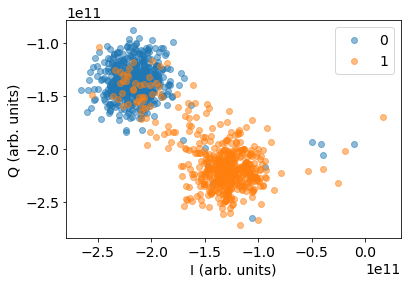

In [14]:
plt.rcParams['font.size'] = 14

discriminators[0].plot();

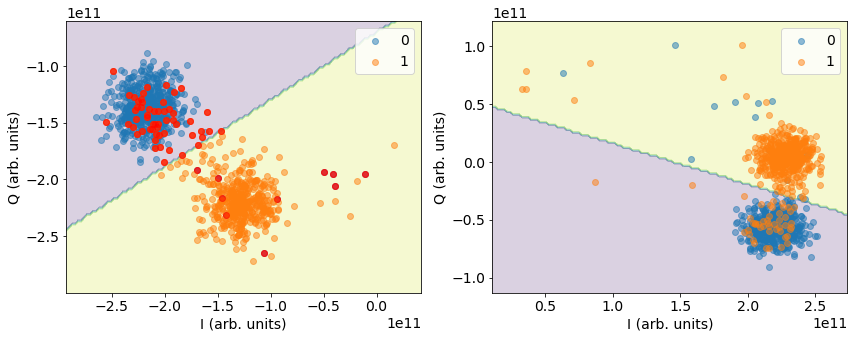

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

discriminators[0].plot(ax[0], flag_misclassified=True, show_boundary=True)
discriminators[1].plot(ax[1], flag_misclassified=False, show_boundary=True);

### Multi-qubit discriminator
The code below illustrates a discriminator that discriminates the '00' from the '11' state. This is thus a multi-qubit discriminator with a four-dimensional decision space. In this case it is no longer possible to properly illustrate the four-dimensional decision boundary using two-dimensional plots.

In [17]:
discriminators_2q = LinearIQDiscriminator(cal_results, [0, 1], ['00', '11'])

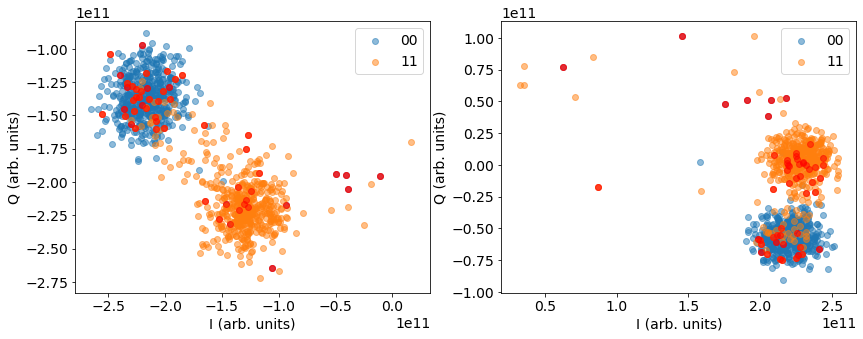

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))

axs, _ = discriminators_2q.plot(axs, flag_misclassified=True)

## 3) Creating a filter associated to the discriminator

We can create a filter based on the discriminator to convert level 1 data into level 2 data. This filter can then be used to discriminate subsequent data.

In [21]:
from qiskit.ignis.measurement.discriminator.filters import DiscriminationFilter

Extract from the original result the experiment(s) that we want to discriminate.

In [22]:
experiment_result = result_subset(result, [experiment_name])

Create the filters based on the discriminators.

In [23]:
filters = {}

for q in qubits:
    filters[q] = DiscriminationFilter(discriminators[q])

Use the filters to create new results with the level 2 data.

In [24]:
results_lvl2 = {}

for q in qubits:
    results_lvl2[q] = filters[q].apply(experiment_result)

Plot the result.

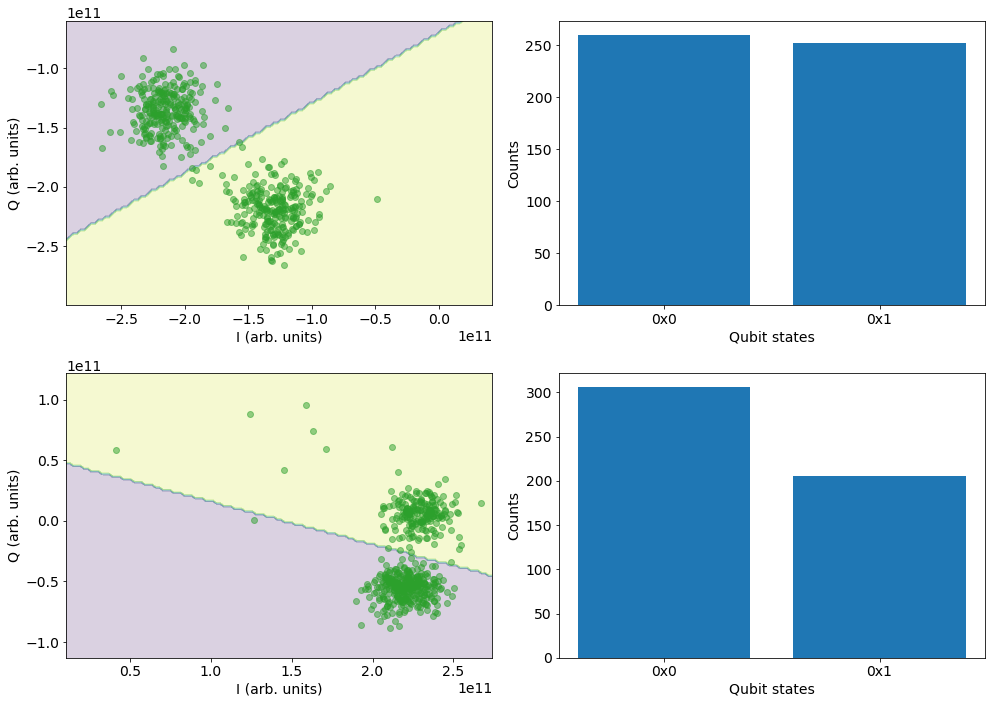

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(14,10))

for q in [0, 1]:
    discriminators[q].plot(ax[q, 0], show_fitting_data=False, show_boundary=True)
    discriminators[q].plot_xdata(ax[q, 0], experiment_result)
    
    counts = results_lvl2[q].results[0].data.counts.to_dict()
    
    ax[q, 1].bar(counts.keys(), counts.values())
    ax[q, 1].set_xlabel('Qubit states')
    ax[q, 1].set_ylabel('Counts')
    
fig.tight_layout()